In [26]:
import numpy as np
import torch
from scipy import optimize
from sim.cartpole_dc import CartPoleEnv
import csv
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.single.local_best import LocalBestPSO
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import tikzplotlib
from util.io import read_data

In [3]:
states, actions = read_data('data.csv')
states = torch.tensor(states).detach()
actions = - torch.tensor([actions]).T.detach()
print(states.shape, actions.shape)

torch.Size([24570, 4]) torch.Size([24570, 1])


In [42]:
def fun(theta, render=False, steps=4):
    env = CartPoleEnv(swingup=True, solver='rk')
    env.Psi = theta[0]
    env.L = theta[1]
    env.max_voltage = theta[2]
    env.transform_factor = theta[3]
    env.reset()
    env.state = states[:len(states)-steps]
    env.i = torch.zeros(len(states)-steps)
    for j in range(steps-1):
        env.step(actions[j:len(states)-(steps-j)])
    s, *_ = env.step(actions[steps-1:len(states)-1])
    s = s.numpy()
    env.close()
    return s

In [52]:
def loss_(theta, steps=4):
    s = fun(theta, steps=steps)
    if (s != s).any():
        #print('nan')
        return [np.inf]
    delta_phi = (states[steps:,2] - s[:,2]) % (2 * np.pi)
    delta_phi = np.minimum(delta_phi, 2*np.pi - delta_phi)**2
    return (0.0 * delta_phi + (states[steps:,0] - s[:,0])**2).numpy()

def loss(theta, steps=4):
    losses = []
    for t in theta:
        losses += [np.sum(loss_(t, steps))]
    print(theta[np.argmin(losses)], np.min(losses))
    return losses


In [47]:
bounds = ([0.05, 0.01, 3.0, 0.67], 
          [5.0, 2.0, 20.0, 1.5])
steps = 4
n_particles = 100
dims = len(bounds[0])
pos = [3.35711521, 0.38367182, 19.35720545, 1.49591271]
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
init_pos = np.random.uniform(low=bounds[0], high=bounds[1], size=(n_particles, dims))
init_pos[0] = pos
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=dims, options=options, bounds=bounds, init_pos=init_pos)
#optimizer = LocalBestPSO(n_particles=n_particles, dimensions=dims, options=options, bounds=bounds)
cost, pos = optimizer.optimize(loss, 100, steps=steps)

2020-04-21 15:43:30,834 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}















pyswarms.single.global_best:   0%|          |0/100














pyswarms.single.global_best:   0%|          |0/100, best_cost=2.19














pyswarms.single.global_best:   1%|          |1/100, best_cost=2.19

[ 2.55010631  0.37995515 18.17642033  1.48951253] 2.1898539066314697

















pyswarms.single.global_best:   1%|          |1/100, best_cost=2.19














pyswarms.single.global_best:   2%|▏         |2/100, best_cost=2.19

[ 3.93284263  0.19686428 19.50920655  1.3790485 ] 2.342078685760498

















pyswarms.single.global_best:   2%|▏         |2/100, best_cost=2.19














pyswarms.single.global_best:   3%|▎         |3/100, best_cost=2.19

[ 3.77807573  0.45403322 18.02608415  1.45080075] 2.247572

















pyswarms.single.global_best:   3%|▎         |3/100, best_cost=2.19














pyswarms.single.global_best:   4%|▍         |4/100, best_cost=2.19

[ 3.97856519  0.69724001 18.39319351  1.45163686] 2.3101249

















pyswarms.single.global_best:   4%|▍         |4/100, best_cost=2.19














pyswarms.single.global_best:   5%|▌         |5/100, best_cost=2.19

[ 3.78651986  0.14879605 18.19241577  1.45942002] 2.197880268096924

















pyswarms.single.global_best:   5%|▌         |5/100, best_cost=2.19














pyswarms.single.global_best:   6%|▌         |6/100, best_cost=2.19

[ 2.67205505  0.62536371 18.0884799   1.481216  ] 2.4254403114318848

















pyswarms.single.global_best:   6%|▌         |6/100, best_cost=2.19














pyswarms.single.global_best:   7%|▋         |7/100, best_cost=2.19

[ 1.50906314  0.24960993 18.62133709  1.49436966] 2.4767026901245117

















pyswarms.single.global_best:   7%|▋         |7/100, best_cost=2.19














pyswarms.single.global_best:   8%|▊         |8/100, best_cost=2.19

[ 2.53053035  0.33774132 17.84235679  1.48883521] 2.2005090713500977

















pyswarms.single.global_best:   8%|▊         |8/100, best_cost=2.19














pyswarms.single.global_best:   9%|▉         |9/100, best_cost=2.19

[ 3.15566542  0.78570116 18.18784758  1.47084346] 2.4572949409484863

















pyswarms.single.global_best:   9%|▉         |9/100, best_cost=2.19














pyswarms.single.global_best:  10%|█         |10/100, best_cost=2.19

[ 3.22920292  0.45652859 18.16277466  1.46684386] 2.208186626434326

















pyswarms.single.global_best:  10%|█         |10/100, best_cost=2.19














pyswarms.single.global_best:  11%|█         |11/100, best_cost=2.19

[ 2.70261828  0.28098353 18.47354243  1.42620109] 2.289501428604126

















pyswarms.single.global_best:  11%|█         |11/100, best_cost=2.1 














pyswarms.single.global_best:  12%|█▏        |12/100, best_cost=2.1

[ 3.45905614  0.50004957 19.36130721  1.47010117] 2.0954998

















pyswarms.single.global_best:  12%|█▏        |12/100, best_cost=2.1














pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=2.1

[ 3.13306494  0.37985393 17.91854343  1.37371721] 2.5827298164367676

















pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=2.1














pyswarms.single.global_best:  14%|█▍        |14/100, best_cost=2.1

[ 4.18826255  0.65021203 18.65911111  1.45407392] 2.2398846

















pyswarms.single.global_best:  14%|█▍        |14/100, best_cost=2.03














pyswarms.single.global_best:  15%|█▌        |15/100, best_cost=2.03

[ 3.31548686  0.40835402 19.34884221  1.49248256] 2.0344353

















pyswarms.single.global_best:  15%|█▌        |15/100, best_cost=2.03














pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=2.03

[ 3.20691611  0.51564559 19.39314849  1.43060598] 2.2562026977539062

















pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=2.03














pyswarms.single.global_best:  17%|█▋        |17/100, best_cost=2.03

[ 3.66264098  0.36937885 19.66448395  1.49933121] 2.0443038940429688

















pyswarms.single.global_best:  17%|█▋        |17/100, best_cost=2.03














pyswarms.single.global_best:  18%|█▊        |18/100, best_cost=2.03

[ 3.5192126   0.43170973 19.1309458   1.45852763] 2.1214661598205566

















pyswarms.single.global_best:  18%|█▊        |18/100, best_cost=2.03














pyswarms.single.global_best:  19%|█▉        |19/100, best_cost=2.03

[ 4.7744559   0.53197944 19.21318997  1.42130101] 2.2979846

















pyswarms.single.global_best:  19%|█▉        |19/100, best_cost=2.03














pyswarms.single.global_best:  20%|██        |20/100, best_cost=2.03

[ 3.27387081  0.3791604  18.5149385   1.47565745] 2.1127987

















pyswarms.single.global_best:  20%|██        |20/100, best_cost=2.03














pyswarms.single.global_best:  21%|██        |21/100, best_cost=2.03

[ 3.30210971  0.42358487 18.82512059  1.48590795] 2.0761265754699707

















pyswarms.single.global_best:  21%|██        |21/100, best_cost=2.03














pyswarms.single.global_best:  22%|██▏       |22/100, best_cost=2.03

[ 4.00984445  0.40590461 18.24806183  1.4979399 ] 2.095724105834961

















pyswarms.single.global_best:  22%|██▏       |22/100, best_cost=2.03














pyswarms.single.global_best:  23%|██▎       |23/100, best_cost=2.03

[ 2.61927     0.50932126 19.41593099  1.49138321] 2.1415079

















pyswarms.single.global_best:  23%|██▎       |23/100, best_cost=2.03














pyswarms.single.global_best:  24%|██▍       |24/100, best_cost=2.03

[ 3.27262221  0.36198689 19.07505369  1.47330483] 2.0775909423828125

















pyswarms.single.global_best:  24%|██▍       |24/100, best_cost=2.03














pyswarms.single.global_best:  25%|██▌       |25/100, best_cost=2.03

[ 3.22719963  0.43731776 19.41019367  1.48954994] 2.0402784

















pyswarms.single.global_best:  25%|██▌       |25/100, best_cost=2.03














pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=2.03

[ 3.16317383  0.67298754 18.24751072  1.46920021] 2.3567352

















pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=2.03














pyswarms.single.global_best:  27%|██▋       |27/100, best_cost=2.03

[ 2.60318931  0.41480786 19.19295242  1.47494347] 2.1535327

















pyswarms.single.global_best:  27%|██▋       |27/100, best_cost=2.03














pyswarms.single.global_best:  28%|██▊       |28/100, best_cost=2.03

[ 3.35434141  0.30307885 19.49091977  1.49952363] 2.0430877

















pyswarms.single.global_best:  28%|██▊       |28/100, best_cost=2.03














pyswarms.single.global_best:  29%|██▉       |29/100, best_cost=2.03

[ 3.39473308  0.55686266 19.32234282  1.42248953] 2.2977609634399414

















pyswarms.single.global_best:  29%|██▉       |29/100, best_cost=2.03














pyswarms.single.global_best:  30%|███       |30/100, best_cost=2.03

[ 3.22172436  0.38027599 18.19847195  1.41141985] 2.3733554

















pyswarms.single.global_best:  30%|███       |30/100, best_cost=2.03














pyswarms.single.global_best:  31%|███       |31/100, best_cost=2.03

[ 3.09487021  0.33538384 19.30719062  1.49020769] 2.0354447

















pyswarms.single.global_best:  31%|███       |31/100, best_cost=2.03














pyswarms.single.global_best:  32%|███▏      |32/100, best_cost=2.03

[ 3.28262989  0.74415827 19.0588333   1.43244545] 2.4509053

















pyswarms.single.global_best:  32%|███▏      |32/100, best_cost=2.03














pyswarms.single.global_best:  33%|███▎      |33/100, best_cost=2.03

[ 3.19031421  0.53878604 19.24390135  1.4857739 ] 2.095211

















pyswarms.single.global_best:  33%|███▎      |33/100, best_cost=2.03














pyswarms.single.global_best:  34%|███▍      |34/100, best_cost=2.03

[ 3.31378844  0.45507714 19.37529698  1.45261947] 2.1360822

















pyswarms.single.global_best:  34%|███▍      |34/100, best_cost=2.03














pyswarms.single.global_best:  35%|███▌      |35/100, best_cost=2.03

[ 3.3440737   0.42020758 19.15207592  1.46881597] 2.0940309

















pyswarms.single.global_best:  35%|███▌      |35/100, best_cost=2.03














pyswarms.single.global_best:  36%|███▌      |36/100, best_cost=2.03

[ 4.02577921  0.48427137 16.14028573  1.48668352] 2.3490944

















pyswarms.single.global_best:  36%|███▌      |36/100, best_cost=2.03














pyswarms.single.global_best:  37%|███▋      |37/100, best_cost=2.03

[ 3.26009148  0.34365599 19.47336398  1.43251036] 2.1521864

















pyswarms.single.global_best:  37%|███▋      |37/100, best_cost=2.03














pyswarms.single.global_best:  38%|███▊      |38/100, best_cost=2.03

[ 3.31401358  0.33829942 19.36614527  1.46322025] 2.0798223

















pyswarms.single.global_best:  38%|███▊      |38/100, best_cost=2.03














pyswarms.single.global_best:  39%|███▉      |39/100, best_cost=2.03

[ 3.80070013  0.45630233 19.36009653  1.38718242] 2.352826

















pyswarms.single.global_best:  39%|███▉      |39/100, best_cost=2.03














pyswarms.single.global_best:  40%|████      |40/100, best_cost=2.03

[ 3.11184952  0.47980941 19.31742453  1.38200649] 2.4593708515167236

















pyswarms.single.global_best:  40%|████      |40/100, best_cost=2.03














pyswarms.single.global_best:  41%|████      |41/100, best_cost=2.03

[ 3.22375458  0.34863212 19.24029188  1.46355127] 2.0880172

















pyswarms.single.global_best:  41%|████      |41/100, best_cost=2.03














pyswarms.single.global_best:  42%|████▏     |42/100, best_cost=2.03

[ 3.27826809  0.50868465 19.34365936  1.40274583] 2.360198

















pyswarms.single.global_best:  42%|████▏     |42/100, best_cost=2.03














pyswarms.single.global_best:  43%|████▎     |43/100, best_cost=2.03

[ 3.30147866  0.43867897 19.27977025  1.47564775] 2.0752015

















pyswarms.single.global_best:  43%|████▎     |43/100, best_cost=2.03














pyswarms.single.global_best:  44%|████▍     |44/100, best_cost=2.03

[ 3.33287545  0.3749396  19.29382168  1.49150362] 2.037628

















pyswarms.single.global_best:  44%|████▍     |44/100, best_cost=2.03














pyswarms.single.global_best:  45%|████▌     |45/100, best_cost=2.03

[ 3.35711521  0.38367182 19.35720545  1.49591271] 2.031041145324707

















pyswarms.single.global_best:  45%|████▌     |45/100, best_cost=2.03














pyswarms.single.global_best:  46%|████▌     |46/100, best_cost=2.03

[ 3.53472741  0.41133176 19.54383869  1.38385211] 2.334902286529541

















pyswarms.single.global_best:  46%|████▌     |46/100, best_cost=2.03














pyswarms.single.global_best:  47%|████▋     |47/100, best_cost=2.03

[ 3.3814635   0.50651441 19.31350649  1.45667414] 2.145988

















pyswarms.single.global_best:  47%|████▋     |47/100, best_cost=2.03














pyswarms.single.global_best:  48%|████▊     |48/100, best_cost=2.03

[ 3.57593677  0.49401765 19.66942948  1.4780196 ] 2.054136276245117

















pyswarms.single.global_best:  48%|████▊     |48/100, best_cost=2.03














pyswarms.single.global_best:  49%|████▉     |49/100, best_cost=2.03

[ 3.31782044  0.40498382 18.8428581   1.49546646] 2.0513107776641846

















pyswarms.single.global_best:  49%|████▉     |49/100, best_cost=2.03














pyswarms.single.global_best:  50%|█████     |50/100, best_cost=2.03

[ 3.89037006  0.91835121 19.36816094  1.47076442] 2.2636738

















pyswarms.single.global_best:  50%|█████     |50/100, best_cost=2.03














pyswarms.single.global_best:  51%|█████     |51/100, best_cost=2.03

[ 3.68933866  0.3130567  19.45086237  1.47318082] 2.0759410858154297

















pyswarms.single.global_best:  51%|█████     |51/100, best_cost=2.03














pyswarms.single.global_best:  52%|█████▏    |52/100, best_cost=2.03

[ 3.05837433  0.40138364 19.81050691  1.48122468] 2.0351915

















pyswarms.single.global_best:  52%|█████▏    |52/100, best_cost=2.03














pyswarms.single.global_best:  53%|█████▎    |53/100, best_cost=2.03

[ 3.20501364  0.40216694 18.92023753  1.47701746] 2.0893537998199463

















pyswarms.single.global_best:  53%|█████▎    |53/100, best_cost=2.03














pyswarms.single.global_best:  54%|█████▍    |54/100, best_cost=2.03

[ 3.44773125  0.44700092 19.08069542  1.47608169] 2.084806442260742

















pyswarms.single.global_best:  54%|█████▍    |54/100, best_cost=2.03














pyswarms.single.global_best:  55%|█████▌    |55/100, best_cost=2.03

[ 3.27954436  0.41061553 19.38548884  1.41835486] 2.232696771621704

















pyswarms.single.global_best:  55%|█████▌    |55/100, best_cost=2.03














pyswarms.single.global_best:  56%|█████▌    |56/100, best_cost=2.03

[ 3.19194305  0.43815507 14.59257423  1.49930203] 2.5630012

















pyswarms.single.global_best:  56%|█████▌    |56/100, best_cost=2.03














pyswarms.single.global_best:  57%|█████▋    |57/100, best_cost=2.03

[ 3.45077359  0.44170306 19.21570281  1.47779445] 2.0713537

















pyswarms.single.global_best:  57%|█████▋    |57/100, best_cost=2.03














pyswarms.single.global_best:  58%|█████▊    |58/100, best_cost=2.03

[ 3.44131134  0.32196885 17.07976888  1.40298979] 2.5011466

















pyswarms.single.global_best:  58%|█████▊    |58/100, best_cost=2.03














pyswarms.single.global_best:  59%|█████▉    |59/100, best_cost=2.03

[ 3.19265268  0.44743604 19.70167943  1.36125046] 2.470191

















pyswarms.single.global_best:  59%|█████▉    |59/100, best_cost=2.03














pyswarms.single.global_best:  60%|██████    |60/100, best_cost=2.03

[ 3.5931841   0.28307335 19.47651913  1.38028641] 2.3130581

















pyswarms.single.global_best:  60%|██████    |60/100, best_cost=2.03














pyswarms.single.global_best:  61%|██████    |61/100, best_cost=2.03

[ 3.35659741  0.37931547 19.310353    1.43779256] 2.1567311

















pyswarms.single.global_best:  61%|██████    |61/100, best_cost=2.03














pyswarms.single.global_best:  62%|██████▏   |62/100, best_cost=2.03

[ 3.20970475  0.39257555 17.920086    1.45031723] 2.2602692

















pyswarms.single.global_best:  62%|██████▏   |62/100, best_cost=2.03














pyswarms.single.global_best:  63%|██████▎   |63/100, best_cost=2.03

[ 3.43457114  0.42555161 19.23123366  1.47752531] 2.0683951377868652

















pyswarms.single.global_best:  63%|██████▎   |63/100, best_cost=2.03














pyswarms.single.global_best:  64%|██████▍   |64/100, best_cost=2.03

[ 4.07332402  0.48694263 17.69790203  1.49676717] 2.1446971893310547

















pyswarms.single.global_best:  64%|██████▍   |64/100, best_cost=2.03














pyswarms.single.global_best:  65%|██████▌   |65/100, best_cost=2.03

[ 3.44978386  0.44036853 19.25190136  1.37305612] 2.4326610565185547

















pyswarms.single.global_best:  65%|██████▌   |65/100, best_cost=2.03














pyswarms.single.global_best:  66%|██████▌   |66/100, best_cost=2.03

[ 3.34619797  0.40714682 19.37887682  1.33141684] 2.5948104858398438

















pyswarms.single.global_best:  66%|██████▌   |66/100, best_cost=2.03














pyswarms.single.global_best:  67%|██████▋   |67/100, best_cost=2.03

[ 3.40211097  0.39344211 19.30882509  1.48983163] 2.0405678749084473

















pyswarms.single.global_best:  67%|██████▋   |67/100, best_cost=2.03














pyswarms.single.global_best:  68%|██████▊   |68/100, best_cost=2.03

[ 3.07122472  0.34452068 18.27358264  1.47952186] 2.119685

















pyswarms.single.global_best:  68%|██████▊   |68/100, best_cost=2.03














pyswarms.single.global_best:  69%|██████▉   |69/100, best_cost=2.03

[ 3.34865638  0.41768884 19.3692953   1.48654477] 2.0436878204345703

















pyswarms.single.global_best:  69%|██████▉   |69/100, best_cost=2.03














pyswarms.single.global_best:  70%|███████   |70/100, best_cost=2.03

[ 3.31019364  0.36039994 19.38214995  1.40927257] 2.2407538890838623

















pyswarms.single.global_best:  70%|███████   |70/100, best_cost=2.03














pyswarms.single.global_best:  71%|███████   |71/100, best_cost=2.03

[ 3.57470214  0.71278659 19.35396691  1.46128877] 2.2182903

















pyswarms.single.global_best:  71%|███████   |71/100, best_cost=2.03














pyswarms.single.global_best:  72%|███████▏  |72/100, best_cost=2.03

[ 2.8252276   0.44773378 19.26625968  1.41312111] 2.361579

















pyswarms.single.global_best:  72%|███████▏  |72/100, best_cost=2.03














pyswarms.single.global_best:  73%|███████▎  |73/100, best_cost=2.03

[ 3.24320608  0.43060247 19.42837357  1.47445445] 2.0689144134521484

















pyswarms.single.global_best:  73%|███████▎  |73/100, best_cost=2.03














pyswarms.single.global_best:  74%|███████▍  |74/100, best_cost=2.03

[ 3.35009056  0.33023956 19.62517921  1.47095504] 2.0558714866638184

















pyswarms.single.global_best:  74%|███████▍  |74/100, best_cost=2.03














pyswarms.single.global_best:  75%|███████▌  |75/100, best_cost=2.03

[ 3.63790062  0.45805886 19.28256338  1.46890354] 2.089470148086548

















pyswarms.single.global_best:  75%|███████▌  |75/100, best_cost=2.03














pyswarms.single.global_best:  76%|███████▌  |76/100, best_cost=2.03

[ 3.27578391  0.42868151 17.13954982  1.39071864] 2.626605272293091

















pyswarms.single.global_best:  76%|███████▌  |76/100, best_cost=2.03














pyswarms.single.global_best:  77%|███████▋  |77/100, best_cost=2.03

[ 4.00975186  0.73568912 18.67312349  1.4819837 ] 2.1828394

















pyswarms.single.global_best:  77%|███████▋  |77/100, best_cost=2.03














pyswarms.single.global_best:  78%|███████▊  |78/100, best_cost=2.03

[ 3.37173384  0.38188019 19.26111472  1.45552646] 2.1105938

















pyswarms.single.global_best:  78%|███████▊  |78/100, best_cost=2.03














pyswarms.single.global_best:  79%|███████▉  |79/100, best_cost=2.03

[ 3.32017439  0.4276101  19.35924429  1.48975983] 2.03972

















pyswarms.single.global_best:  79%|███████▉  |79/100, best_cost=2.03














pyswarms.single.global_best:  80%|████████  |80/100, best_cost=2.03

[ 2.96217261  0.42883533 19.31035219  1.4447407 ] 2.191094

















pyswarms.single.global_best:  80%|████████  |80/100, best_cost=2.03














pyswarms.single.global_best:  81%|████████  |81/100, best_cost=2.03

[ 3.32522009  0.4007426  19.34104595  1.42652334] 2.2000908851623535

















pyswarms.single.global_best:  81%|████████  |81/100, best_cost=2.03














pyswarms.single.global_best:  82%|████████▏ |82/100, best_cost=2.03

[ 3.92827641  0.52636646 17.66833091  1.46192031] 2.271481

















pyswarms.single.global_best:  82%|████████▏ |82/100, best_cost=2.03














pyswarms.single.global_best:  83%|████████▎ |83/100, best_cost=2.03

[ 3.25393838  0.39679413 18.71780033  1.46951359] 2.12028169631958

















pyswarms.single.global_best:  83%|████████▎ |83/100, best_cost=2.03














pyswarms.single.global_best:  84%|████████▍ |84/100, best_cost=2.03

[ 3.88359055  0.70466311 19.69434126  1.44442546] 2.2121825

















pyswarms.single.global_best:  84%|████████▍ |84/100, best_cost=2.03














pyswarms.single.global_best:  85%|████████▌ |85/100, best_cost=2.03

[ 3.31296954  0.41115091 18.65496161  1.44390209] 2.2089791

















pyswarms.single.global_best:  85%|████████▌ |85/100, best_cost=2.03














pyswarms.single.global_best:  86%|████████▌ |86/100, best_cost=2.03

[ 3.57363931  0.26674372 18.80021254  1.48101606] 2.0875905

















pyswarms.single.global_best:  86%|████████▌ |86/100, best_cost=2.03














pyswarms.single.global_best:  87%|████████▋ |87/100, best_cost=2.03

[ 3.11577441  0.39971739 17.73770504  1.48414525] 2.1735725

















pyswarms.single.global_best:  87%|████████▋ |87/100, best_cost=2.03














pyswarms.single.global_best:  88%|████████▊ |88/100, best_cost=2.03

[ 3.65059075  0.23524307 19.22974003  1.40561207] 2.24573

















pyswarms.single.global_best:  88%|████████▊ |88/100, best_cost=2.03














pyswarms.single.global_best:  89%|████████▉ |89/100, best_cost=2.03

[ 3.54144611  0.56417512 19.22121025  1.49185596] 2.0658545

















pyswarms.single.global_best:  89%|████████▉ |89/100, best_cost=2.03














pyswarms.single.global_best:  90%|█████████ |90/100, best_cost=2.03

[ 3.12935435  0.39880548 19.31934094  1.47506306] 2.0706391

















pyswarms.single.global_best:  90%|█████████ |90/100, best_cost=2.03














pyswarms.single.global_best:  91%|█████████ |91/100, best_cost=2.03

[ 3.73509129  0.37704236 18.29527612  1.46967969] 2.1444662

















pyswarms.single.global_best:  91%|█████████ |91/100, best_cost=2.03














pyswarms.single.global_best:  92%|█████████▏|92/100, best_cost=2.03

[ 3.29573098  0.39200129 19.36509299  1.36933127] 2.420145

















pyswarms.single.global_best:  92%|█████████▏|92/100, best_cost=2.03














pyswarms.single.global_best:  93%|█████████▎|93/100, best_cost=2.03

[ 3.33944668  0.38232795 19.48229922  1.48882646] 2.035079002380371

















pyswarms.single.global_best:  93%|█████████▎|93/100, best_cost=2.03














pyswarms.single.global_best:  94%|█████████▍|94/100, best_cost=2.03

[ 3.22983901  0.64023256 15.82133451  1.46677466] 2.6710465

















pyswarms.single.global_best:  94%|█████████▍|94/100, best_cost=2.03














pyswarms.single.global_best:  95%|█████████▌|95/100, best_cost=2.03

[ 3.35889576  0.50632663 18.34874602  1.45252966] 2.2562382

















pyswarms.single.global_best:  95%|█████████▌|95/100, best_cost=2.03














pyswarms.single.global_best:  96%|█████████▌|96/100, best_cost=2.03

[ 3.64551472  0.45178694 19.26386912  1.34932534] 2.530676

















pyswarms.single.global_best:  96%|█████████▌|96/100, best_cost=2.03














pyswarms.single.global_best:  97%|█████████▋|97/100, best_cost=2.03

[ 3.38409872  0.4225688  19.35395529  1.47980353] 2.057129

















pyswarms.single.global_best:  97%|█████████▋|97/100, best_cost=2.03














pyswarms.single.global_best:  98%|█████████▊|98/100, best_cost=2.03

[ 3.40845362  0.42534864 19.3625802   1.43206816] 2.1851956844329834

















pyswarms.single.global_best:  98%|█████████▊|98/100, best_cost=2.03














pyswarms.single.global_best:  99%|█████████▉|99/100, best_cost=2.03

[ 3.36071849  0.38332237 19.45243688  1.46518835] 2.0763368606567383

















pyswarms.single.global_best:  99%|█████████▉|99/100, best_cost=2.03














pyswarms.single.global_best: 100%|██████████|100/100, best_cost=2.03
2020-04-21 15:55:29,493 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.031041145324707, best pos: [ 3.35711521  0.38367182 19.35720545  1.49591271]


[ 3.06074144  0.33162487 18.21096226  1.46791126] 2.1548218727111816


[ 3.35711521  0.38367182 19.35720545  1.49591271]


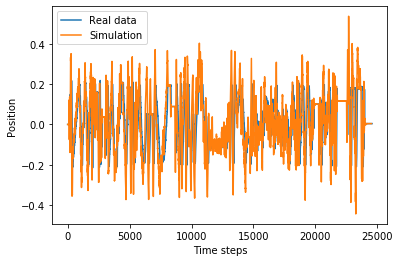

/Users/bastian/miniconda3/envs/ml/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/bastian/miniconda3/envs/ml/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


119.74111


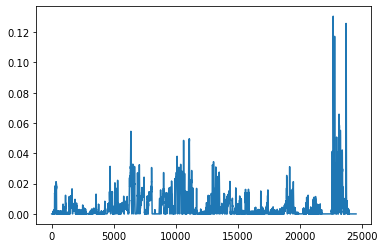

In [53]:
print(pos)
s = fun(pos, steps=50)

plt.figure()
a, = plt.plot(states[:,0], label='Real data')
b, = plt.plot(s[:,0], label='Simulation')
plt.xlabel('Time steps')
plt.ylabel('Position')
plt.legend(handles=[a,b])
tikzplotlib.save("cartfit.tex")
plt.show()

plt.figure()
plt.plot(loss_(pos, steps=50))
print(np.sum(loss_(pos, steps=50)))

In [49]:
optimize.least_squares(loss_, pos, bounds=bounds)

 active_mask: array([0, 0, 0, 0, 0])
        cost: 0.011053385213017464
         fun: array([2.2737371e-14, 2.2737371e-14, 2.2737371e-14, ..., 3.8595318e-09,
       3.8595318e-09, 3.8595318e-09], dtype=float32)
        grad: array([-0.00391693,  0.        ,  0.02159393,  0.01855953, -0.01856432])
         jac: array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 19
        njev: 8
  optimality: 0.030112236070514414
      status: 3
     success: True
           x: array([2.26273920e-01, 7.77691616e-01, 1.40447706e+00, 1.35050072e-03,
       1.65104690e-02])